<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW5_boosting_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [247]:
import pandas as pd

In [248]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [249]:
category_col = ['experience_level', 'employment_type', 'remote_ratio', 'company_size']

categories  = {'experience_level' : ['SE', 'MI', 'EN', 'EX'], 'employment_type' : ['FT', 'PT', 'CT', 'FL'], 'remote_ratio' : [0, 50, 100], 'company_size' : ['S', 'M', 'L']}

In [250]:
for col in category_col:
    if len(set(df[col]) - set(categories[col])) == 0:
        print(f'В колонке {col} нет ошибочных значений')
    else:
        print(f'В колонке {col} есть ошибочные значения')
        print(set(df[col]) - set(categories[col]))


В колонке experience_level нет ошибочных значений
В колонке employment_type нет ошибочных значений
В колонке remote_ratio нет ошибочных значений
В колонке company_size нет ошибочных значений


## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


В датасете нет пропусков

In [252]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [253]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


На первый взгляд выбросы отсутствуют все значения больше 0. Но зарплата в 5132 USD привлекает внимание на проверку.

In [254]:
df[df['salary_in_usd'] == 5132]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2684,2022,MI,FT,NLP Engineer,120000,CZK,5132,CZ,100,CZ,M


По курсу 1 CZK = 0,042 USD ЗП получилась равная 4997 USD. Данное значение - не выброс.

In [255]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [256]:
df.tail()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
3754,2021,SE,FT,Data Science Manager,7000000,INR,94665,IN,50,IN,L


In [257]:
df[df.duplicated()]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
115,2023,SE,FT,Data Scientist,150000,USD,150000,US,0,US,M
123,2023,SE,FT,Analytics Engineer,289800,USD,289800,US,0,US,M
153,2023,MI,FT,Data Engineer,100000,USD,100000,US,100,US,M
154,2023,MI,FT,Data Engineer,70000,USD,70000,US,100,US,M
160,2023,SE,FT,Data Engineer,115000,USD,115000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
3439,2022,MI,FT,Data Scientist,78000,USD,78000,US,100,US,M
3440,2022,SE,FT,Data Engineer,135000,USD,135000,US,100,US,M
3441,2022,SE,FT,Data Engineer,115000,USD,115000,US,100,US,M
3586,2021,MI,FT,Data Engineer,200000,USD,200000,US,100,US,L


В данных есть полные дубликаты, удалим их.

In [258]:
df = df.drop_duplicates(ignore_index=True)

Проверим уникальные значения в названиях должностей:

In [259]:
df['job_title'].unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Machine Learning Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Sc

В данных есть одна и та же должность - 'ML Engineer' и 'Machine Learning Engineer'. Заменим ее на ML Engineer.

In [260]:
df['job_title'] = df['job_title'].apply(lambda x: 'ML Engineer' if x == 'Machine Learning Engineer' else x)

In [261]:
df.shape

(2584, 11)

Объединим похожие должности в одну, чтобы уменьшить кол-во классов.

In [262]:
df['job_title'].unique()

array(['Principal Data Scientist', 'ML Engineer', 'Data Scientist',
       'Applied Scientist', 'Data Analyst', 'Data Modeler',
       'Research Engineer', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Data Strategist',
       'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Compliance Data Analyst',
       'Data Architect', 'Applied Machine Learning Engineer',
       'AI Developer', 'Research Scientist', 'Data Analytics Manager',
       'Business Data Analyst', 'Applied Data Scientist',
       'Staff Data Analyst', 'ETL Engineer', 'Data DevOps Engineer',
       'Head of Data', 'Data Science Manager', 'Data Manager',
       'Machine Learning Researcher', 'Big Data Engineer',
       'Data Specialist', 'Lead Data Analyst', 'BI Data Engineer',
       'Director of Data Science', 'Machine Learning Scientist',
       'MLOps Engineer', 'AI Scientist', 'Autonomous Vehicle Technician',
       'Applied Machine Learning Scientist', 'Lead Data Scientis

In [263]:
df['job_title'] = df['job_title'].apply(lambda x: x.replace('Machine Learning', 'ML'))
df['job_title'] = df['job_title'].apply(lambda x: x.replace('Applied', '').strip() if x != 'Applied Scientist' else x)
df['job_title'] = df['job_title'].apply(lambda x: x.replace('Principal', '').strip())
df['job_title'] = df['job_title'].apply(lambda x: 'ML Engineer' if 'ML Engineer' in x else x)
df['job_title'] = df['job_title'].apply(lambda x: 'Data Scientist' if 'Data Scientist' in x else x)
df['job_title'] = df['job_title'].apply(lambda x: 'Data Analyst' if 'Data Analyst' in x else x)
df['job_title'] = df['job_title'].apply(lambda x: 'Data Engineer' if 'Data Engineer' in x else x)
df['job_title'] = df['job_title'].apply(lambda x: 'BI Developer' if 'Power BI Developer' in x else x)


In [264]:
df['job_title'].unique()

array(['Data Scientist', 'ML Engineer', 'Applied Scientist',
       'Data Analyst', 'Data Modeler', 'Research Engineer',
       'Analytics Engineer', 'Business Intelligence Engineer',
       'Data Strategist', 'Data Engineer', 'Computer Vision Engineer',
       'Data Quality Analyst', 'Data Architect', 'AI Developer',
       'Research Scientist', 'Data Analytics Manager', 'ETL Engineer',
       'Data DevOps Engineer', 'Head of Data', 'Data Science Manager',
       'Data Manager', 'ML Researcher', 'Data Specialist',
       'Director of Data Science', 'ML Scientist', 'MLOps Engineer',
       'AI Scientist', 'Autonomous Vehicle Technician',
       'Cloud Database Engineer', 'Data Infrastructure Engineer',
       'AI Programmer', 'Data Operations Engineer', 'BI Developer',
       'Data Science Lead', 'Deep Learning Researcher', 'BI Analyst',
       'Data Science Consultant', 'Data Analytics Specialist',
       'ML Infrastructure Engineer', 'Head of Data Science',
       'Insight Analyst', 

In [265]:
c = df['job_title'].value_counts()

Удалим категории, которые составляют менее 2% от всех данных

In [266]:
jobs = c[c<50].index

In [267]:
df['job_title'] = df['job_title'].apply(lambda x: None if x in jobs else x)

In [268]:
df = df.dropna()

In [269]:
df.shape

(2159, 11)

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2159 entries, 0 to 2583
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           2159 non-null   int64 
 1   experience_level    2159 non-null   object
 2   employment_type     2159 non-null   object
 3   job_title           2159 non-null   object
 4   salary              2159 non-null   int64 
 5   salary_currency     2159 non-null   object
 6   salary_in_usd       2159 non-null   int64 
 7   employee_residence  2159 non-null   object
 8   remote_ratio        2159 non-null   int64 
 9   company_location    2159 non-null   object
 10  company_size        2159 non-null   object
dtypes: int64(4), object(7)
memory usage: 202.4+ KB


In [271]:
df.head(10)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
7,2023,SE,FT,Data Scientist,219000,USD,219000,CA,0,CA,M
8,2023,SE,FT,Data Scientist,141000,USD,141000,CA,0,CA,M
9,2023,SE,FT,Data Scientist,147100,USD,147100,US,0,US,M
10,2023,SE,FT,Data Scientist,90700,USD,90700,US,0,US,M
11,2023,SE,FT,Data Analyst,130000,USD,130000,US,100,US,M


In [272]:
indexs = []
for ind, row in df.iterrows():
    if(row['employee_residence'] != row['company_location']):
        indexs.append(ind)


In [273]:
print(f'В датасете {len(indexs)} ({round(len(indexs) / df.shape[0] *100, 3)}%) сотрудников с разными странами в местоположении компании и регионом проживания')

В датасете 63 (2.918%) сотрудников с разными странами в местоположении компании и регионом проживания


2,918% - это очень малое значение, поэтому мы можем удалить столбец "employee_residence" или "company_location". На ЗП сотрудника чаще всего влияет местоположение компании, чем его место проживания, поэтому удаляем "employee_residence"

In [274]:
df = df.drop(columns= 'employee_residence')

**Задача -** Прогнозирование salary_in_usd (ЗП)

- **work_year:** год, в который взяты данные - по корреляции она может влиять на ЗП. Также из-за инфляции каждый год оплата сотрудникам должна индексироваться, поэтому  год может оказаться полезным.
- **experience_level:** уровень опыта - очень сильно влияет на ЗП (Джун и Сеньор зарабатывают по разному).
- **employment_type:** тип занятости (FT, PT, CT, FL) - сколько и как работает человек - тоже влияет на ЗП (фуллтайм или парт тайм).
- **job_title:** название рабочей позиции в компании - в зависимости от должности меняется ЗП 
- **salary:** зараплата на позиции - ЗП в USD зависит от данного параметра и salary_currency
- **salary_currency:** валюта в которой начисляют зарплату - ЗП в USD зависит от данного параметра и salary
- employee_residence: страна или регион проживания сотрудника - у 4% сотрудников город проживания отличается от метоположения компании, поэтому удалили данный столбец, чтобы было меньше повторных признаков.
- **remote_ratio:** процент удаленки, предлагаемый в компании (0, 50, 100) - может влиять на ЗП
- **company_location:** местоположение компании - очень сильно влияет на ЗП - в разных странах  должности оцениваются по разному
- **company_size:** размер компании, оцененный как S, M, L - размер компании может влиять на ЗП - часто в небольших компаниях может быть меньше ЗП, чтобы компания могла быстрее расти


In [275]:
for c in df.columns:
    print(f'В признаке {c}: {len(df[c].value_counts().index)} категорий.')

В признаке work_year: 4 категорий.
В признаке experience_level: 4 категорий.
В признаке employment_type: 4 категорий.
В признаке job_title: 8 категорий.
В признаке salary: 744 категорий.
В признаке salary_currency: 17 категорий.
В признаке salary_in_usd: 926 категорий.
В признаке remote_ratio: 3 категорий.
В признаке company_location: 63 категорий.
В признаке company_size: 3 категорий.


## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [276]:
y = df['salary_in_usd']
X = df.drop(columns = 'salary_in_usd')

In [277]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [278]:
X.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'remote_ratio', 'company_location',
       'company_size'],
      dtype='object')

In [279]:
#непрерывные признаки
cont_X_train = X_train[['work_year', 'salary']].copy()
cont_X_test = X_test[['work_year', 'salary']].copy()
cont_y_train = y_train.copy()
cont_y_test = y_test.copy()

#непрерывные признаки
all_X_train = X_train.copy()
all_X_test = X_test.copy()
all_y_train = y_train.copy()
all_y_test = y_test.copy()


## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [280]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(cont_X_train, cont_y_train)
y_pred_lr = model_lr.predict(cont_X_test)


In [281]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error

print(f'MAPE: {mean_absolute_percentage_error(cont_y_test, y_pred_lr)}')
print(f'RMSE: {root_mean_squared_error(cont_y_test, y_pred_lr)}')

MAPE: 0.7554042969210673
RMSE: 59557.23610150315


**Вывод:** MAPE и RMSE достаточно высокие. Это означает, что прогнозы ЗП модели линейной регрессии имеют очень высокое отклонение от реальной ЗП. Качество модели - плохое.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [282]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(cont_X_train, cont_y_train)
y_pred_xgb = xgb.predict(cont_X_test)

In [283]:
print(f'MAPE: {mean_absolute_percentage_error(cont_y_test, y_pred_xgb)}')
print(f'RMSE: {root_mean_squared_error(cont_y_test, y_pred_xgb)}')

MAPE: 0.05526161193847656
RMSE: 8963.7646484375


**Вывод:** MAPE и RMSE маленькие. Модель получилась хорошая - прогнозируемая ЗП может отличаться на 9к от реальной, это конечно высокое значение, но в сравнении с моделью лин. регрессией качество уже намного лучше.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [284]:
from category_encoders.one_hot import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, TargetEncoder

In [285]:
import category_encoders
print(category_encoders.__version__)

2.8.0


In [286]:
cat_col = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'company_location', 'company_size']

In [287]:
train_OHE = all_X_train.copy()
test_OHE = all_X_test.copy()

p_OHE_lr = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),
                     ('model_', LinearRegression())])
p_OHE_xgb = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),
                     ('model_', XGBRegressor())])

p_OHE_lr.fit(train_OHE, all_y_train)
y_pred_OHE = p_OHE_lr.predict(test_OHE)
print('Линейная регрессия:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_OHE)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_OHE)}')

p_OHE_xgb.fit(train_OHE, all_y_train)
y_pred_OHE_xgb = p_OHE_xgb.predict(test_OHE)
print('xgboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_OHE_xgb)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_OHE_xgb)}')

Линейная регрессия:
MAPE: 0.5193252960163307
RMSE: 68059.01943232829
xgboost:
MAPE: 0.0202960055321455
RMSE: 2934.677001953125


In [288]:
train_LE = all_X_train.copy()
test_LE = all_X_test.copy()

for col in cat_col:
    le = LabelEncoder()
    joined = pd.concat([train_LE[col], test_LE[col]])
    le.fit(joined)
    train_LE[col] = le.transform(train_LE[col])
    test_LE[col] = le.transform(test_LE[col])

model_LR_LE = LinearRegression()
model_LR_LE.fit(train_LE, all_y_train)
y_pred_LR = model_LR_LE.predict(test_LE)

print('Линейная регрессия:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_LR)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_LR)}')

xgb_LE = XGBRegressor()
xgb_LE.fit(train_LE, all_y_train)
y_pred_xgb_LE = xgb_LE.predict(test_LE)

print('xgboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_xgb_LE)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_xgb_LE)}')

Линейная регрессия:
MAPE: 0.5105166600512211
RMSE: 51993.29727971438
xgboost:
MAPE: 0.06198759377002716
RMSE: 8129.07373046875


In [289]:
from category_encoders import TargetEncoder

train_MTE = all_X_train.copy()
test_MTE = all_X_test.copy()

p_MTE_lr = Pipeline([('target_encoder', TargetEncoder(cols=cat_col)),
                     ('model_', LinearRegression())])
p_MTE_xgb = Pipeline([('target_encoder_', TargetEncoder(cols=cat_col)),
                     ('model_', XGBRegressor())])

p_MTE_lr.fit(train_MTE, all_y_train)
y_pred = p_MTE_lr.predict(test_MTE)
print('Линейная регрессия:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred)}')

p_MTE_xgb.fit(train_MTE, all_y_train)
y_pred = p_MTE_xgb.predict(test_MTE)
print('xgboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred)}')

Линейная регрессия:
MAPE: 0.4819620883391064
RMSE: 50235.54069101034
xgboost:
MAPE: 0.04036812484264374
RMSE: 15515.7568359375


**Топ методов и моделей по качеству:** 
| Метод предобработки | Модель | MAPE | RMSE |
| --- | --- | --- | --- |
| OHE | XGBoost | 0.020 | 2934.677 |
| LabelEncoding | XGBoost | 0.062 | 8129.074 |
| MeanTargerEnc| XGBoost | 0.040 | 15515.757 |
| MeanTargerEnc| LinearRegression | 0.482 | 50235.541 |
| LabelEncoding | LinearRegression | 0.511 | 51993.297 |
| OHE | LinearRegression | 0.519 | 68059.019 |

Модели XGBoost получили метрики намного ниже чем модели линейной регрессии при использовании любого метода предобработки. Также можно заметить, что методы предобработки в таблице заркально отражены по горизонтали - это значит, что разные методы могут влиять на модель по разному, для каждой модели и данных лучше пробовать несколько методов предобработки и смотреть на результат. 

Модели линейной регрессии получились очень плохими - они больше угадывают результаты чем предсказывают.

Самое лучшее качество получилось у модели XGBoost и метода OHE. Отклонения в предсказанной зарплате около 3000 usd, MAPE также небольшой  2%. Далее будем продолжать работать с ней.


## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [290]:
test_OHE['test'] = all_y_test
test_OHE['pred'] = y_pred_OHE_xgb
test_OHE['diff_salary'] = abs(all_y_test - y_pred_OHE_xgb)

In [291]:
test_OHE.sort_values(by=['diff_salary'], ascending=False).head(20)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,remote_ratio,company_location,company_size,test,pred,diff_salary
1563,2022,EN,FT,Data Scientist,6600000,HUF,100,HU,M,17684,45263.839844,27579.839844
2248,2022,EX,FT,Data Engineer,324000,USD,100,US,M,324000,348323.593750,24323.593750
2469,2021,SE,FT,ML Engineer,4900000,INR,0,IN,L,66265,84856.828125,18591.828125
2483,2021,SE,FT,Research Scientist,120500,CAD,50,CA,L,96113,110534.187500,14421.187500
2307,2021,MI,FT,ML Engineer,7000000,JPY,50,JP,S,63711,77281.960938,13570.960938
2376,2020,EN,FT,ML Engineer,250000,USD,50,US,L,250000,263234.937500,13234.937500
1736,2022,SE,FT,Data Engineer,210000,CAD,50,CA,M,161311,148172.687500,13138.312500
2327,2021,EN,PT,Data Analyst,8760,EUR,50,ES,M,10354,20846.332031,10492.332031
2314,2022,SE,FT,Data Scientist,148000,EUR,100,DE,M,155499,165741.375000,10242.375000
308,2023,SE,FT,ML Engineer,304000,USD,100,US,M,304000,314147.531250,10147.531250


В топ 20 много DataEngineer, у которых неверно предсказывается ЗП.

Для улучшения данных можно испольховать MinMaxScaler для 'salary', и подобрать категории для 'work_year', 'remote_ratio' или добавить их в OHE

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [292]:
cat_col.append('work_year')
cat_col.append('remote_ratio')

In [293]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or MinMaxScaler()

    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

In [294]:
train_OHE = all_X_train.copy()
test_OHE = all_X_test.copy()

p_OHE_xgb = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),
                      ('scaler_', CustomScaler(['salary'])),
                     ('model_', XGBRegressor())])

p_OHE_xgb.fit(train_OHE, all_y_train)
y_pred_OHE_xgb = p_OHE_xgb.predict(test_OHE)
print('xgboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_OHE_xgb)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_OHE_xgb)}')

xgboost:
MAPE: 0.02156713791191578
RMSE: 2900.9970703125


Было: MAPE = 0.020, RMSE = 2934.677

Стало: MAPE = 0.022 (увеличилось на 0.002), RMSE = 2900.997 (уменьшилось  на 33.68).

Модель стала лучше после доработок.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [295]:
from catboost import CatBoostRegressor

In [296]:
train_catb = all_X_train.copy()
test_catb = all_X_test.copy()

In [297]:
model = CatBoostRegressor(cat_features = cat_col, logging_level='Silent', iterations=1, learning_rate=1, depth=1)
model.fit(train_catb, all_y_train)
preds = model.predict(test_catb)
print('catboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, preds)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, preds)}')

catboost:
MAPE: 0.6142999580413693
RMSE: 43498.29875850148


| Параметры | time | MAPE | RMSE |
|---|---|---|---|
|Стандартные|19,7|0.055|4701.909|
|iterations=2, learning_rate=1, depth=2|1.5|0.410|30681.565|
|iterations=3, learning_rate=1, depth=3|0|0.246|18226.248|
|iterations=10, learning_rate=1, depth=10|2|0.095|9582.409|
|iterations=100, learning_rate=1, depth=16|101.5|0.101|10093.759|
|iterations=500, learning_rate=1, depth=8|18.5|0.060|5794.216|
|iterations=10000, learning_rate=1, depth=8|405.6|0.060|5796.930|
|iterations=500, learning_rate=1, depth=16|1701.3|0.081|7506.845|

Самые лучшие результаты получились при стандартных гиперпараметрах - на так много времени затрачено, но качество метрик наилучшее из полученных.

Модель получилась чуть хуже чем xgboost в 11 задании, но результат все равно очень хороший.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [298]:
train_xgb = all_X_train.copy()
test_xgb = all_X_test.copy()

p_xgb = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),
                     ('model_', XGBRegressor())])

p_xgb.fit(train_xgb, all_y_train)
y_pred_xgb = p_xgb.predict(test_xgb)
print('xgboost:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_xgb)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_xgb)}')

xgboost:
MAPE: 0.02156713791191578
RMSE: 2900.9970703125


| Параметры | time | MAPE | RMSE |
|---|---|---|---|
|Стандартные|3.8|0.0216|2900.997|
|n_estimators=1000, max_depth=1, eta=0.1, subsample=1, colsample_bytree=1|0.8|0.0916|8971.930|
|n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8|2.9|0.0355|4151.350|
|n_estimators=10000, max_depth=10, eta=0.01, subsample=1, colsample_bytree=1|16.9|0.020|3525.850|
|n_estimators=10000, max_depth=10, eta=0.7, subsample=0, colsample_bytree=0|5|0.8153|61721.008|
|n_estimators=100000, max_depth=1, eta=0.3, subsample=0, colsample_bytree=0|51.2|0.8153|61721.008|
|n_estimators=10, max_depth=1, eta=0.3, subsample=0, colsample_bytree=0|0.2|0.8153|61721.008|
|n_estimators=100000, max_depth=10, eta=0.001, subsample=1, colsample_bytree=1|323.1|0.021|3589.460|


Лушчее качество модели по метрикам и времени получились у стандартных гиперпараметров. Качество модели получилось очень хорошее.

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [299]:
from lightgbm import LGBMRegressor

In [300]:
'''
train_lgbm = all_X_train.copy()
test_lgbm = all_X_test.copy()

p_lgbm = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),
                     ('model_', LGBMRegressor())])

p_lgbm.fit(train_lgbm, all_y_train)
y_pred_lgbm = p_lgbm.predict(test_lgbm)
print('lgbm:')
print(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_lgbm)}')
print(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_lgbm)}')
'''

"\ntrain_lgbm = all_X_train.copy()\ntest_lgbm = all_X_test.copy()\n\np_lgbm = Pipeline([('one_hot_encoder_', OneHotEncoder(cols=cat_col)),\n                     ('model_', LGBMRegressor())])\n\np_lgbm.fit(train_lgbm, all_y_train)\ny_pred_lgbm = p_lgbm.predict(test_lgbm)\nprint('lgbm:')\nprint(f'MAPE: {mean_absolute_percentage_error(all_y_test, y_pred_lgbm)}')\nprint(f'RMSE: {root_mean_squared_error(all_y_test, y_pred_lgbm)}')\n"

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

**Вывод:**
1. По качеству модель XGBRegressor со стандартными параметрами показала лучшие метрики - MAPE = 0.0216, RMSE =  2900.997.
2. По совокупным результатам модель XGBRegressor со стандартными параметрами показала лучшие метрики - MAPE = 0.0216, RMSE =  2900.997 и время time = 3.8 секунд.
3. Бустинги очень сильно превзошли по качеству линейную регрессию в данном случае. Их целесообразно использовать, если очень мало выбросов


# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [301]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

C:\Users\DARYA\AppData\Local\Temp\ipykernel_2640\2740943932.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-darkgrid'])


### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [302]:
with open('samsung_test_labels.txt') as f:
    y_test = f.read().split('\n')[:-1]

with open('samsung_train_labels.txt') as f:
    y_train = f.read().split('\n')[:-1]


In [303]:
len(y_test)

2947

In [304]:
len(y_train)

7352

In [305]:
def get_data(file):
    with open(file) as f:
        data_all = f.read().split('\n')

    data = []

    for row in data_all:
        r = row.split(' ')
        f_r = list(filter(lambda x: x != '', r))
        if len(f_r)>0:
            data.append(f_r)

    return data

In [306]:
train = get_data('samsung_train.txt')

test = get_data('samsung_test.txt')


In [307]:
len(train)

7352

In [308]:
len(test)

2947

In [309]:
X_train = pd.DataFrame(train)
X_test = pd.DataFrame(test)
y_train = pd.DataFrame(y_train).astype('int')
y_test = pd.DataFrame(y_test).astype('int')

In [310]:
# Ваш код здесь
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])
y = y.astype('int')

In [311]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [312]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,2.8858451e-001,-2.0294171e-002,-1.3290514e-001,-9.9527860e-001,-9.8311061e-001,-9.1352645e-001,-9.9511208e-001,-9.8318457e-001,-9.2352702e-001,-9.3472378e-001,...,-7.4323027e-002,-2.9867637e-001,-7.1030407e-001,-1.1275434e-001,3.0400372e-002,-4.6476139e-001,-1.8445884e-002,-8.4124676e-001,1.7994061e-001,-5.8626924e-002
1,2.7841883e-001,-1.6410568e-002,-1.2352019e-001,-9.9824528e-001,-9.7530022e-001,-9.6032199e-001,-9.9880719e-001,-9.7491437e-001,-9.5768622e-001,-9.4306751e-001,...,1.5807454e-001,-5.9505094e-001,-8.6149931e-001,5.3476955e-002,-7.4345661e-003,-7.3262621e-001,7.0351059e-001,-8.4478760e-001,1.8028889e-001,-5.4316717e-002
2,2.7965306e-001,-1.9467156e-002,-1.1346169e-001,-9.9537956e-001,-9.6718701e-001,-9.7894396e-001,-9.9651994e-001,-9.6366837e-001,-9.7746859e-001,-9.3869155e-001,...,4.1450281e-001,-3.9074815e-001,-7.6010372e-001,-1.1855926e-001,1.7789948e-001,1.0069921e-001,8.0852908e-001,-8.4893347e-001,1.8063731e-001,-4.9117815e-002
3,2.7917394e-001,-2.6200646e-002,-1.2328257e-001,-9.9609149e-001,-9.8340270e-001,-9.9067510e-001,-9.9709947e-001,-9.8274984e-001,-9.8930250e-001,-9.3869155e-001,...,4.0457253e-001,-1.1729020e-001,-4.8284451e-001,-3.6787973e-002,-1.2892494e-002,6.4001104e-001,-4.8536645e-001,-8.4864938e-001,1.8193476e-001,-4.7663183e-002
4,2.7662877e-001,-1.6569655e-002,-1.1536185e-001,-9.9813862e-001,-9.8081727e-001,-9.9048163e-001,-9.9832113e-001,-9.7967187e-001,-9.9044113e-001,-9.4246912e-001,...,8.7753013e-002,-3.5147093e-001,-6.9920515e-001,1.2332005e-001,1.2254196e-001,6.9357829e-001,-6.1597061e-001,-8.4786525e-001,1.8515116e-001,-4.3892254e-002


In [313]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10299 entries, 0 to 2946
Columns: 561 entries, 0 to 560
dtypes: object(561)
memory usage: 44.2+ MB


In [314]:
X = X.astype('float')
X_train = X_train.astype('float')
X_test = X_test.astype('float')

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [315]:
from sklearn.preprocessing import StandardScaler

In [316]:
# Ваш код здесь
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [317]:
X_scaled[0][:5]

array([ 0.21053385, -0.06870264, -0.45219453, -0.88333495, -0.94543102])

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [318]:
from sklearn.decomposition import PCA

In [319]:
# Ваш код здесь
pca = PCA(100, random_state=RANDOM_STATE)
pca.fit(X_scaled)
print(sum(pca.explained_variance_ratio_))

0.9467114549071658


In [320]:
X_pca = pca.transform(X_scaled)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [321]:
len(X_pca)

10299

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [322]:
f_plot = [r[0] for r in X_pca] #первая главная компонента
s_plot = [r[1] for r in X_pca] #вторая главная компонента

In [323]:
data_plot = {'x':f_plot, 'y':s_plot, 'label':y[0]}

In [324]:
df_plot = pd.DataFrame(data_plot)

In [325]:
labels = [1,2,3,4,5,6]

C:\Users\DARYA\AppData\Local\Temp\ipykernel_2640\1830315531.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')


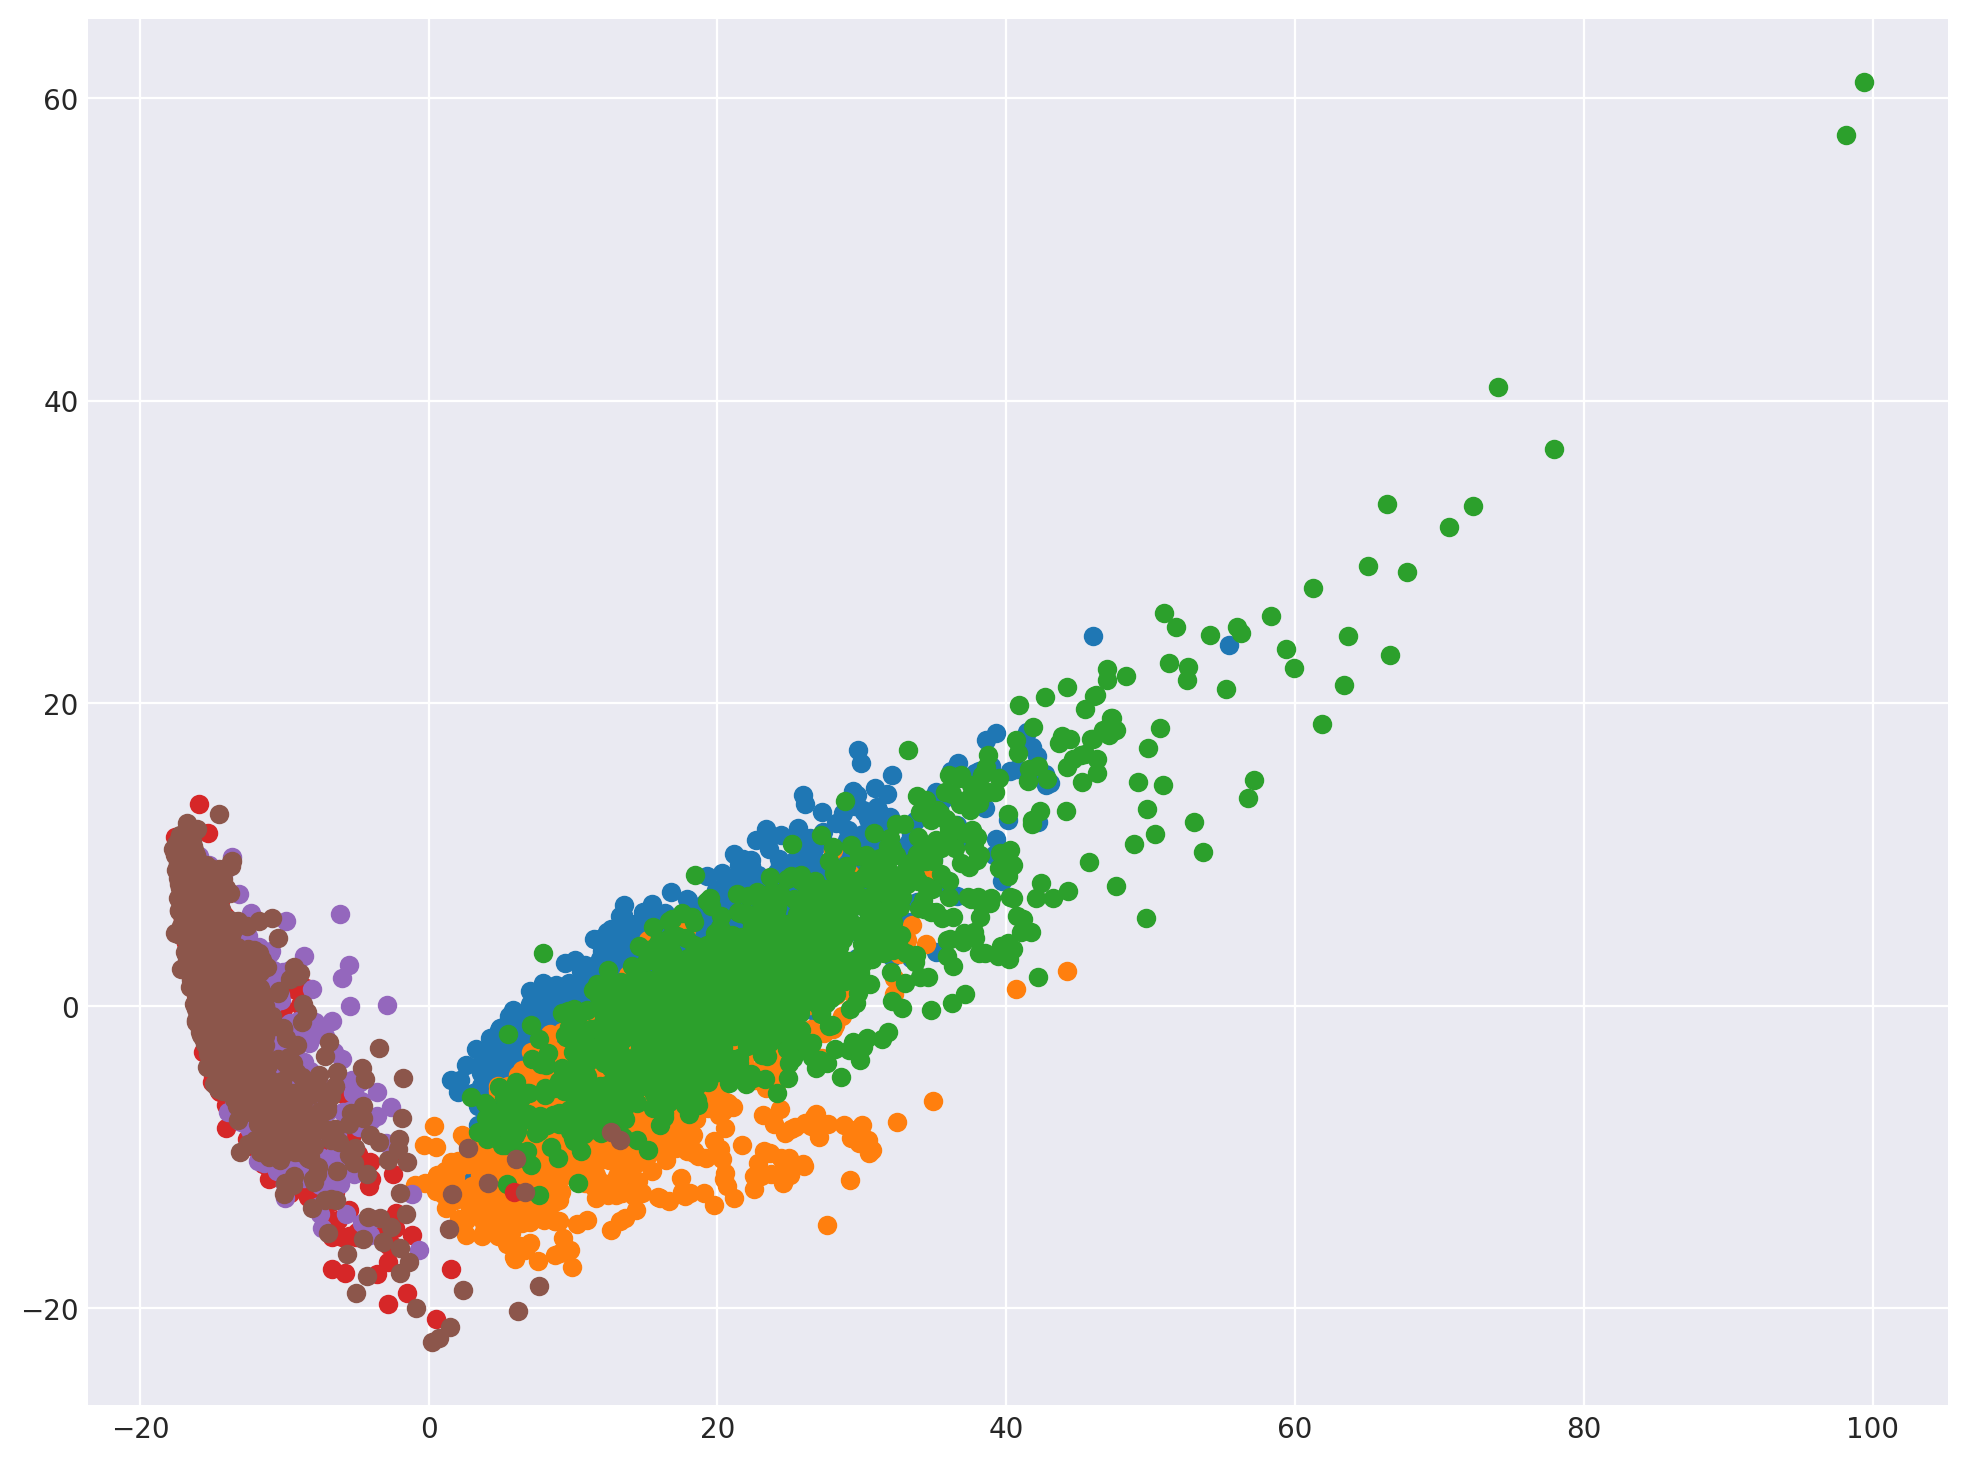

In [326]:
for i in labels:
    plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')

plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [327]:
from sklearn.cluster import KMeans

In [328]:
# Классы в датасете начинаются с 1 , а в моделях с 1, поэтому приведен их к единому виду
y_test[0] = y_test[0].apply(lambda x: x -1)
y_train[0] = y_train[0].apply(lambda x: x -1)

In [329]:
#Время обучения - 4,1 секунды
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)
kmeans.fit(X_train, y_train)

KMeans(n_clusters=6, n_init=100, random_state=42)

In [330]:
#Время инференса - 0.0135 секунды
import time
start = time.time()
predict_classes = kmeans.predict(X_test)
print(f'Время инференса = {round(time.time() - start, 4)} секунды')

Время инференса = 0.006 секунды


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [331]:
f_plot = [r[0] for r in X_test] #первая главная компонента
s_plot = [r[1] for r in X_test] #вторая главная компонента

data_plot = {'x':f_plot, 'y':s_plot, 'label': predict_classes}

df_plot = pd.DataFrame(data_plot)

C:\Users\DARYA\AppData\Local\Temp\ipykernel_2640\1790146324.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')


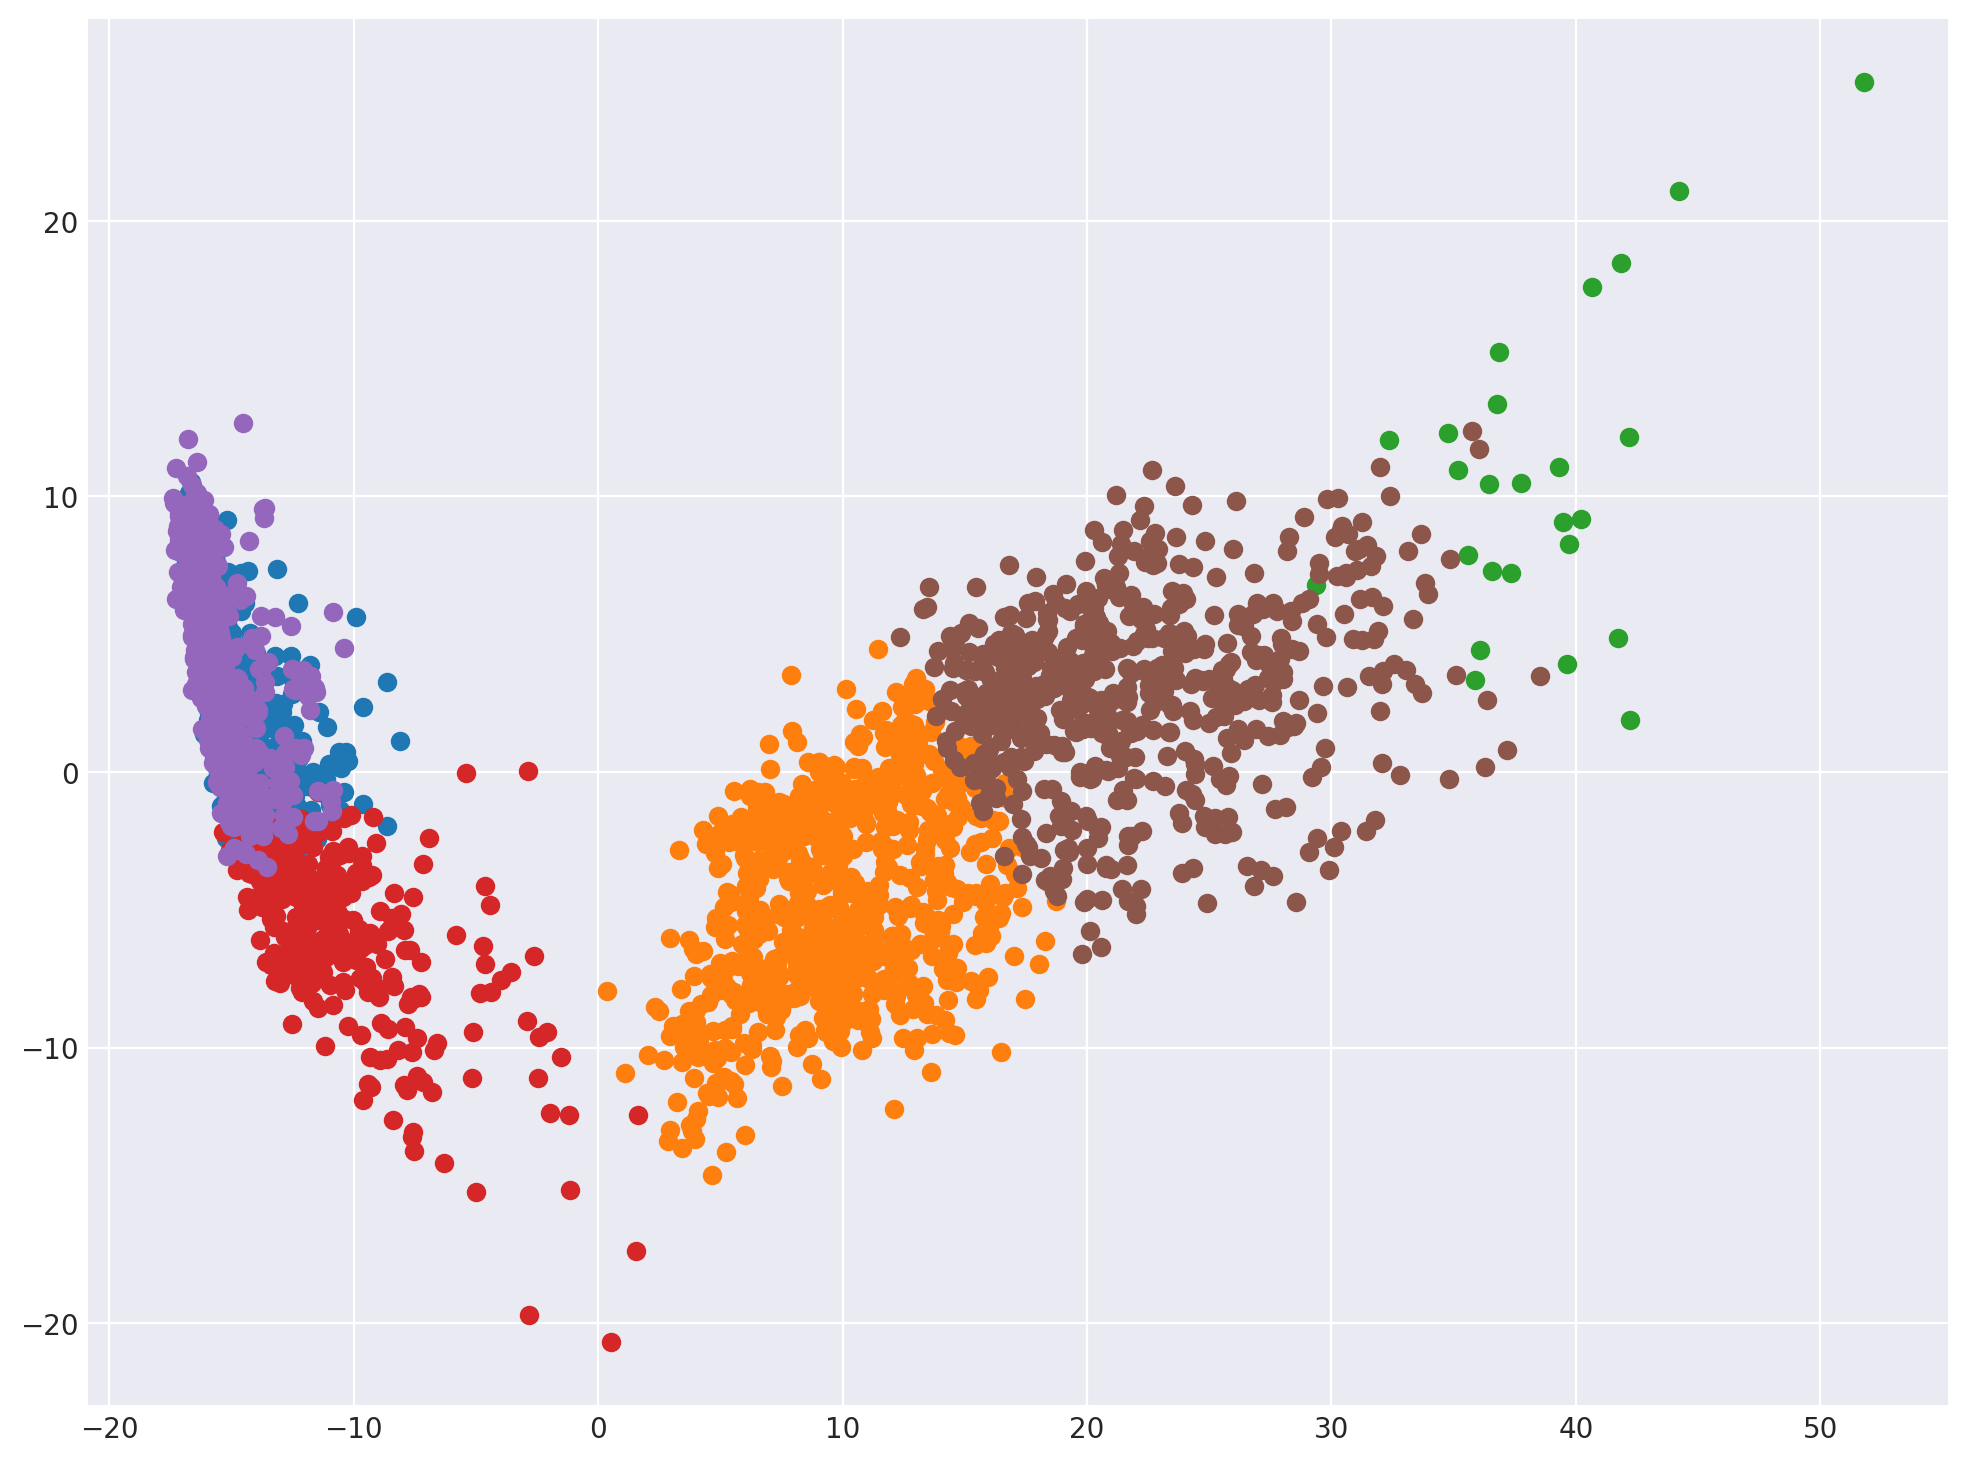

In [332]:
for i in range(0, 6):
    plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')

plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [333]:
y[0].value_counts()

0
6    1944
5    1906
4    1777
1    1722
2    1544
3    1406
Name: count, dtype: int64

In [334]:
y_test.value_counts()

0
5    537
4    532
0    496
3    491
1    471
2    420
Name: count, dtype: int64

Я буду использовать weighted average precision и weighted average recall - для определения доли правильных предсказаний состояния человека в сравнении со всеми правильными предсказаниями модели и доли правильно предсказанных классов от всех положительных примеров. Эти метрики позволят нам понять, можно ли работать с состояниями человека после предсказания модели, либо это случайные данные.

In [335]:
set(predict_classes)

{0, 1, 2, 3, 4, 5}

In [336]:
y_test.value_counts()

0
5    537
4    532
0    496
3    491
1    471
2    420
Name: count, dtype: int64

In [337]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predict_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       496
           1       0.52      0.86      0.64       471
           2       0.76      0.05      0.09       420
           3       0.34      0.24      0.28       491
           4       0.00      0.00      0.00       532
           5       0.00      0.00      0.00       537

    accuracy                           0.18      2947
   macro avg       0.27      0.19      0.17      2947
weighted avg       0.25      0.18      0.16      2947



weighted avg precision и recall  маленькие (0.25 и 0.18). Если проанализировать всю матрицу, то можно увидеть, что правильная классификация была у состояний 1-3. Все остальные состояния определены неверно. Данную модель сейчас нельзя использовать.

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [338]:
from sklearn.cluster import AgglomerativeClustering

In [339]:
clustering = AgglomerativeClustering(n_clusters=6)
clustering.fit(X_train, y_train)

AgglomerativeClustering(n_clusters=6)

Время обучения - 4,8 секунды.

In [340]:
pred = clustering.fit_predict(X_test)

Время инференса - 0,4 секунды.

In [341]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.49      0.70      0.58       496
           1       0.00      0.00      0.00       471
           2       0.11      0.13      0.12       420
           3       0.38      0.26      0.31       491
           4       0.00      0.00      0.00       532
           5       0.05      0.06      0.05       537

    accuracy                           0.19      2947
   macro avg       0.17      0.19      0.18      2947
weighted avg       0.17      0.19      0.17      2947



In [342]:
f_plot = [r[0] for r in X_test] #первая главная компонента
s_plot = [r[1] for r in X_test] #вторая главная компонента

data_plot = {'x':f_plot, 'y':s_plot, 'label': pred}

df_plot = pd.DataFrame(data_plot)

C:\Users\DARYA\AppData\Local\Temp\ipykernel_2640\1790146324.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')


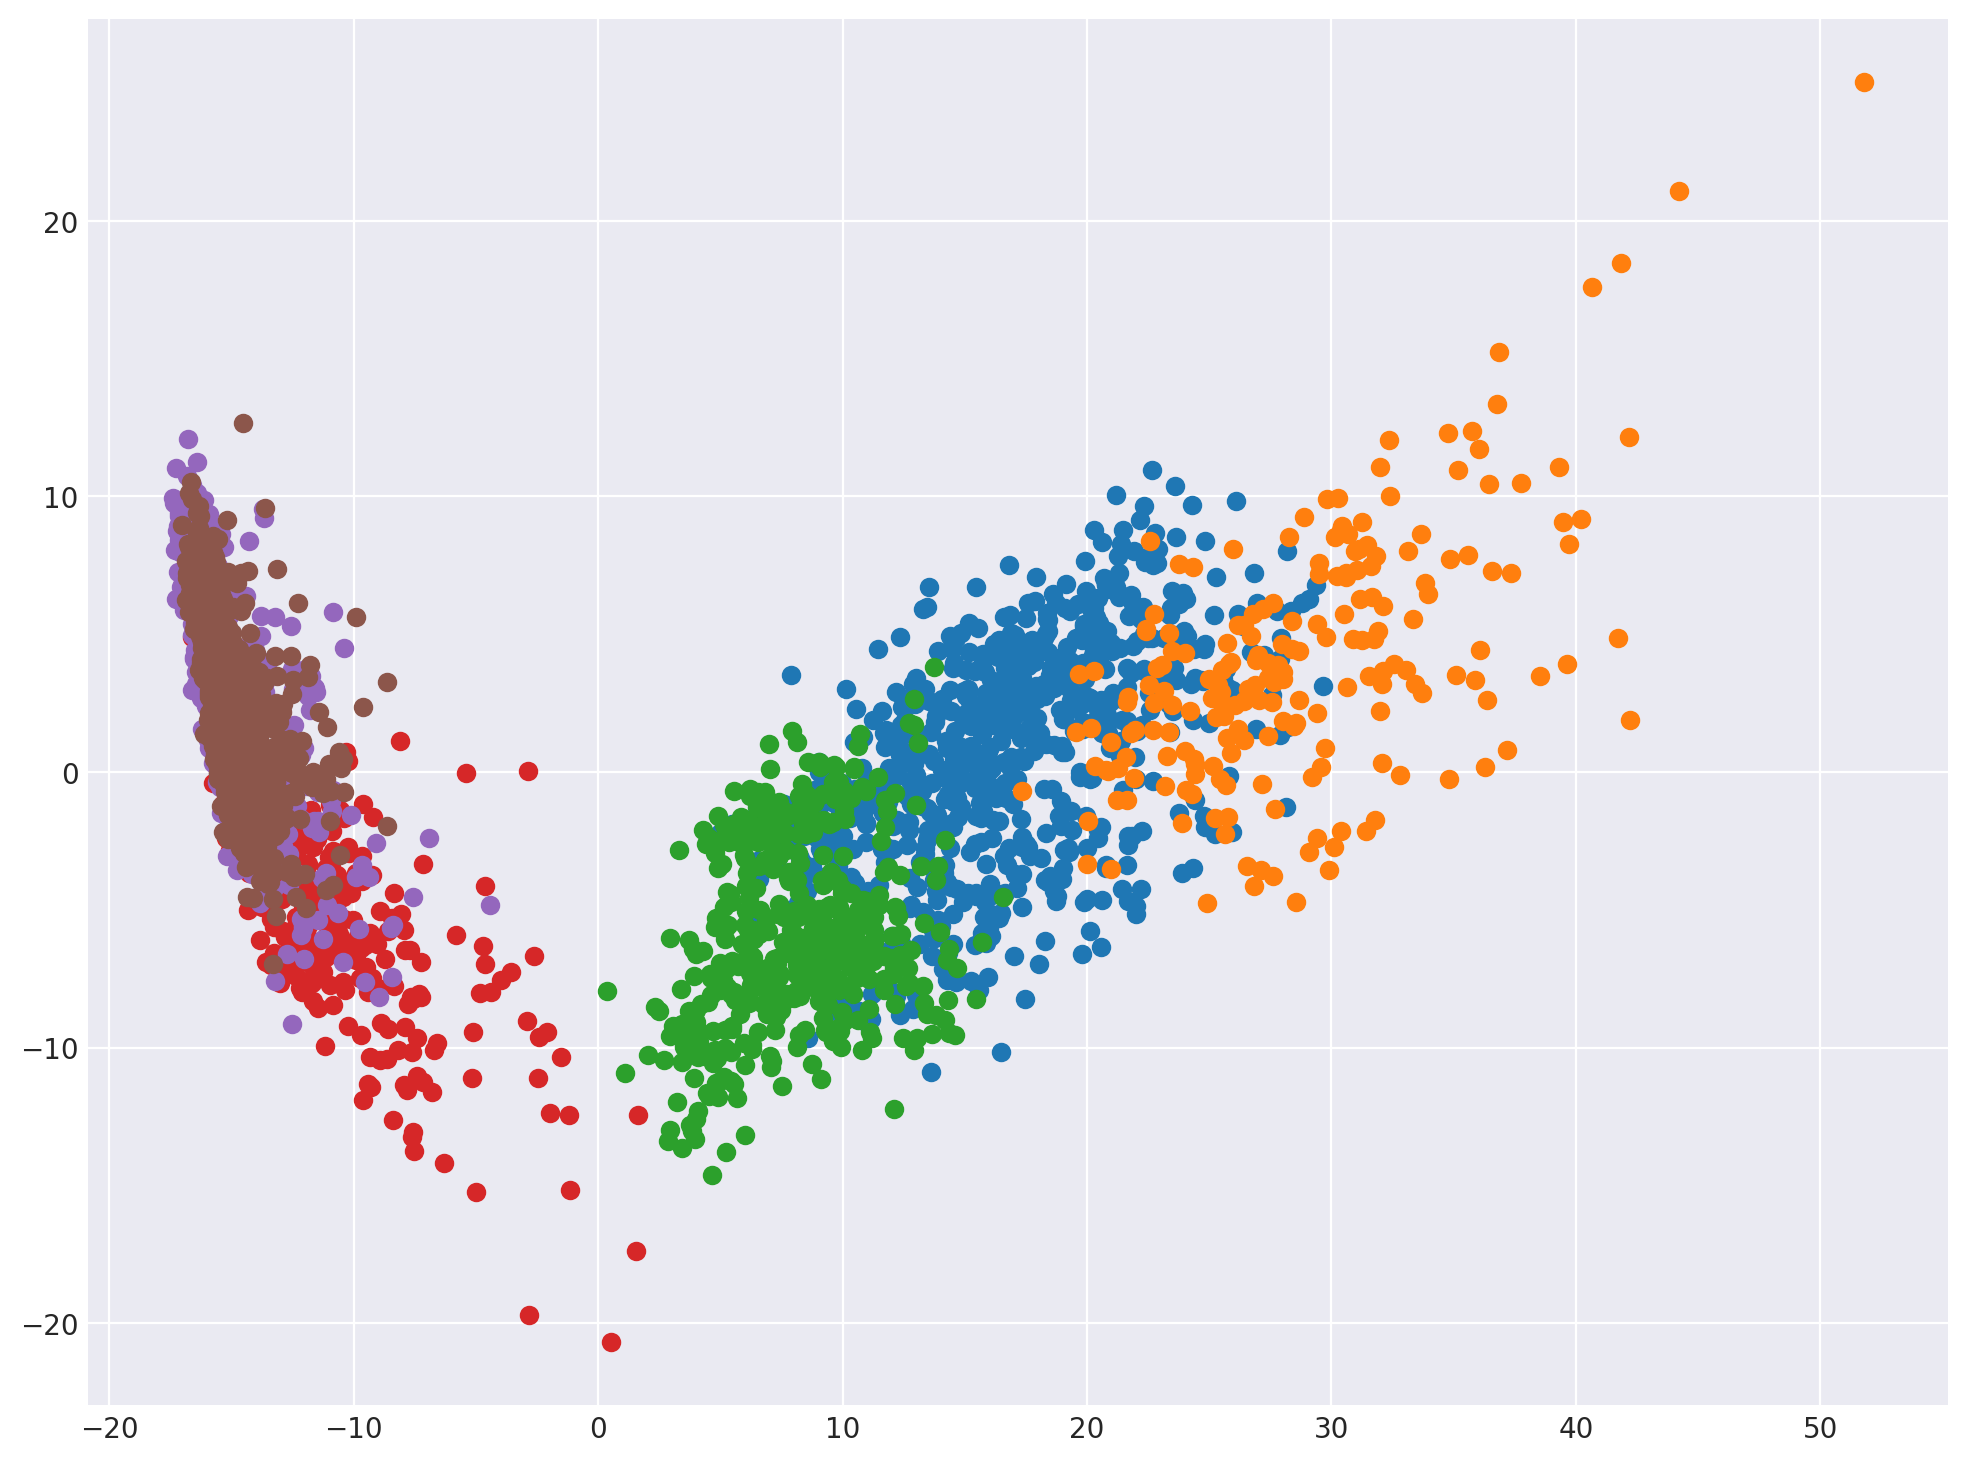

In [343]:
for i in range(0, 6):
    plt.scatter(df_plot[df_plot['label'] == i]['x'], df_plot[df_plot['label'] == i]['y'], cmap='virdis')

plt.show()

**Вывод:**
Засеките время обучения и время инференса. ```KMeans```: обучение - 4,1 секунды, инференс - 0,0135 секунды. ```AgglomerativeClustering```: обучение - 4,8 секунды, инференс - 0,4 секунды. Методу ```AgglomerativeClustering``` требуется больше времени, чем ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
weighted avg recall увеличился на 0.01, weighted avg precision уменьшился на 0.08. В ```KMeans``` корректно определялись только состояния 2-4 (по первоначальным labels), в ```AgglomerativeClustering``` определяются 1, 3-4, 6. По метрикам стало хуже, но по количуству корректно определяемых состояних стало лучше.
* Почему?
Если посмотреть первоначальную визуализацию, то можно заметить, что состояния "наложены" друг на друга. И это мешает методам разделить данные состояния на классы.





### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [344]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [345]:
def find_components(image, lmbd, n_clusters):
    #your code here

SyntaxError: incomplete input (1481975782.py, line 2)

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

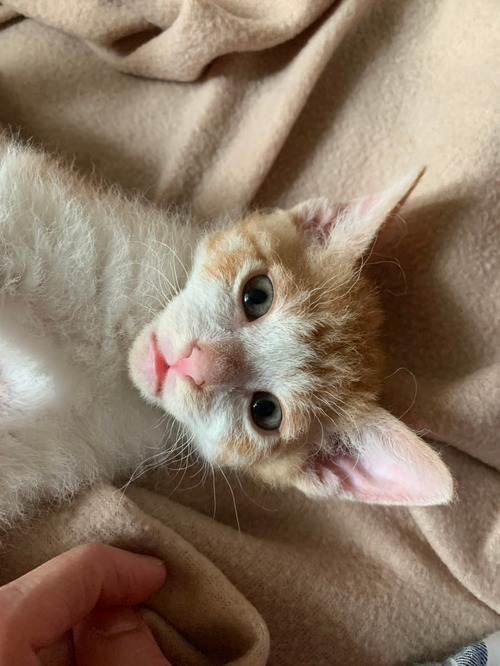